In [1]:
"""Volume 2: Non-negative Matrix Factorization."""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

In [2]:
#Problems 1-2
class NMFRecommender:

    def __init__(self,random_state=15,rank=3,maxiter=200,tol=1e-3):
        """The parameter values for the algorithm"""
        # initialize everything as self variables
        self.random_state = random_state
        self.rank = rank
        self.maxiter = maxiter
        self.tol = tol

        
    
    def initialize_matrices(self,m,n):
        """randomly initialize the W and H matrices"""
        np.random.seed(self.random_state) # seed random so we can have repeatability

        # create W and H
        self.W = np.random.random((m,self.rank))
        self.H = np.random.random((self.rank,n))
        return self.W, self.H

      
    def fit(self,V):
        """Fits W and H weight matrices using CVXPY"""
        
        # function to solve for W given H
        def solve_W():
            new_W = cp.Variable(self.W.shape, nonneg = True)
            objW = cp.Minimize(cp.norm(V-new_W@self.H, 'fro'))
            probW = cp.Problem(objW)
            probW.solve()
            return new_W.value

        # function to solve for H given W
        def solve_H():
            new_H = cp.Variable(self.H.shape, nonneg = True)
            objH = cp.Minimize(cp.norm(V-self.W@new_H, 'fro'))
            probH = cp.Problem(objH)
            probH.solve()
            return new_H.value
        
        for i in range(self.maxiter):
            # create copies to compare to later
            old_W = self.W.copy()
            old_H = self.H.copy()

            # solve for W and then solve for H
            self.W = solve_W()
            self.H = solve_H()

            # compare the old and new W and H to 
            if np.linalg.norm(old_W - self.W, ord='fro') < self.tol and np.linalg.norm(old_H - self.H, ord = 'fro') < self.tol:
                break


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""
        return self.W@self.H


In [3]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )
    # create an instance of the class
    World_Health_Organization = NMFRecommender(rank=2)
    m,n = V.shape

    # initialize W and H, then fit
    World_Health_Organization.initialize_matrices(m,n)
    World_Health_Organization.fit(V)

    # get W and H rounded to 2 decimal places
    W,H = np.round(World_Health_Organization.W,2), np.round(World_Health_Organization.H,2)

    # create a mask for how many people have greater component two than one
    mask = H[0,:] <= H[1,:]
    return W,H, sum(mask)

In [4]:
W,H,total = prob3()
print(f'W:\n{W}')
print(f'H:\n{H}')
print(f'sum: {total}')

W:
[[0.43 1.56]
 [0.73 2.67]
 [0.26 1.23]
 [2.77 0.  ]
 [0.   0.37]]
H:
[[0.   0.73 1.08 1.45 0.35 0.37]
 [0.59 0.77 0.07 0.   0.8  0.77]]
sum: 4


In [5]:
#get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    #scale image
    image = image / 255
    #reshape image
    image = np.reshape(image,(m,n))
    #show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()


In [6]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """
    # get the faces data
    images = get_faces()
    alphas = [0., .2, .5]
    l1_ratios = [0.,1e-5,10]
    i = 1
    for a in alphas:
        for l1 in l1_ratios:
            # create model
            model = NMF(n_components = 75, alpha = a, l1_ratio=l1)
            print(f'fitting model {a}, {l1}')

            # fit W and H
            W = model.fit_transform(images)
            H = model.components_

            # multiply W by the third column of H so it's faster
            V3 = W@H[:,2]

            # plot the resulting face
            plt.subplot(3,3,i)
            plt.title(f'alpha = {a}; l1 = {l1}')
            plt.axis('off')
            show(V3)
            i += 1
    plt.tight_layout()
    plt.show()

fitting model 0.0, 0.0
fitting model 0.0, 1e-05
fitting model 0.0, 10
fitting model 0.2, 0.0
fitting model 0.2, 1e-05
fitting model 0.2, 10
fitting model 0.5, 0.0
fitting model 0.5, 1e-05
fitting model 0.5, 10


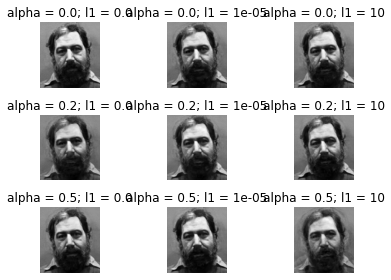

In [7]:
prob4()

In [8]:
def prob5():
    '''
        find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''
    images = get_faces()
    alpha = 0.5
    l1=10
    model = NMF(n_components = 75, alpha = alpha, l1_ratio=l1)
    W = model.fit_transform(images)
    H = model.components_

    max2 = np.argsort(H[:,1])[-10:]
    max12 = np.argsort(H[:,11])[-10:]

    print("Faces closest to 2:")
    for i in max2:
        show(W[:,i], plt_show=True)

    print("Faces closest to 12:")
    for i in max12:
        show(W[:,i], plt_show=True)

    


Faces closest to 2:


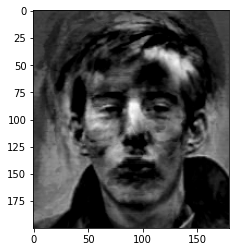

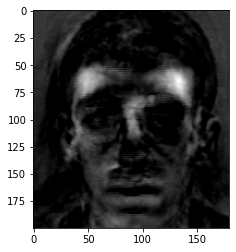

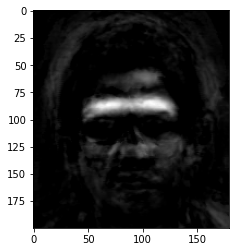

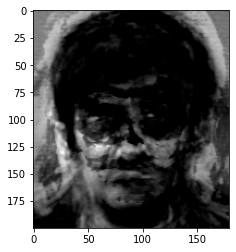

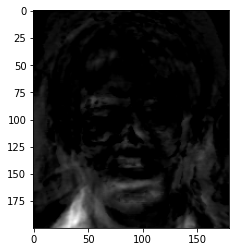

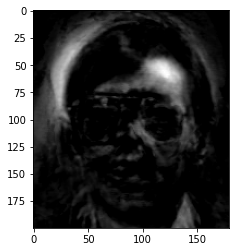

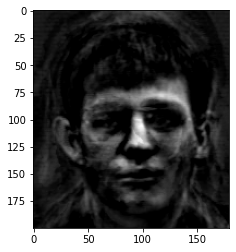

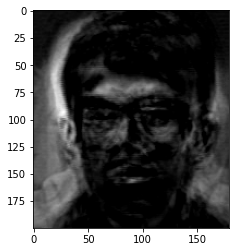

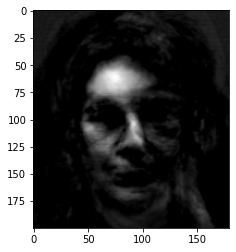

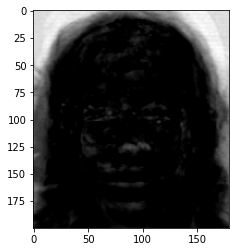

Faces closest to 12:


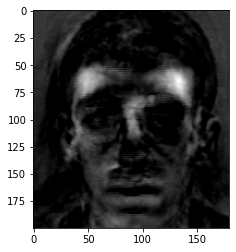

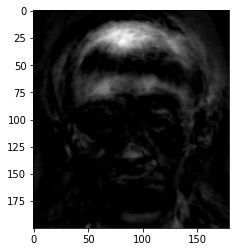

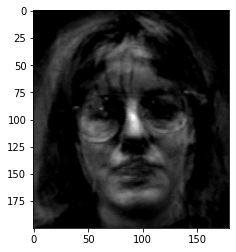

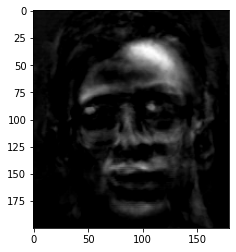

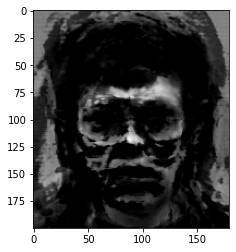

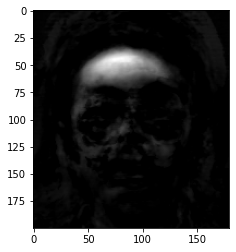

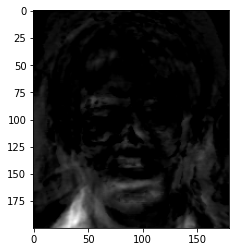

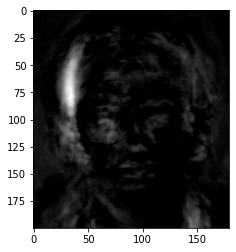

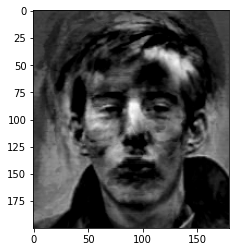

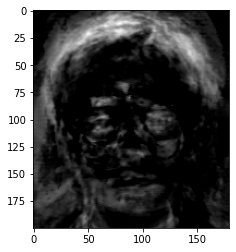

In [9]:
prob5()